In [2]:
import os
import math
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.ndimage.measurements import label
import time
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.measure import label, regionprops
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, \
    GradientBoostingClassifier, RandomForestClassifier

%matplotlib inline

In [4]:
cars=[]
no_cars=[]

images_cars = glob.glob('data/vehicles/*/*.png', recursive=True)
for img_path in images_cars:
    if img_path is None:
        continue
    img = mpimg.imread(img_path)
    cars.append(img)

images_nocars = glob.glob('data/non-vehicles/*/*.png', recursive=True)
for img_path in images_nocars:
    if img_path is None:
        continue
    img = mpimg.imread(img_path)
    no_cars.append(img)

print('files for vehicles size ',len(images_cars),' cars size ',len(cars))
print('files for non-vehicles size ',len(images_nocars),' no_cars size ',len(no_cars))

files for vehicles size  8792  cars size  8792
files for non-vehicles size  8968  no_cars size  8968


In [5]:
def draw2Img(img1,img2,title1,title2):
    layout, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 5))
    layout.tight_layout()
    plt1.imshow(img1)
    plt1.set_title(title1)
    
  
    img2 = np.asarray(img2)
    plt2.imshow(img2)
    plt2.set_title(title2)
    plt.show()

In [6]:
def get_hog_features(img, orient=9, pix_per_cell=2, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

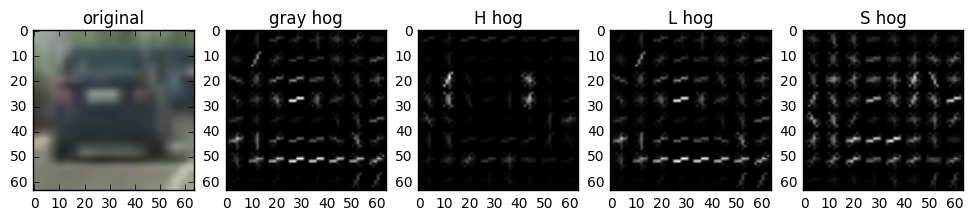

In [14]:
orient=9
pix_per_cell=8
cell_per_block=2

image=mpimg.imread(images_cars[0])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hls  = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

# Plot a figure with all three bar charts
t,axarr = plt.subplots(1, 5, figsize=(12,3))
axarr[0].set_title('original')
axarr[0].imshow(image)

features, gray_hog = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True)
axarr[1].set_title('gray hog')
axarr[1].imshow(gray_hog, cmap='gray')

features, h_hog = get_hog_features(hls[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
axarr[2].set_title('H hog')
axarr[2].imshow(h_hog, cmap='gray')

features, l_hog = get_hog_features(hls[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
axarr[3].set_title('L hog')
axarr[3].imshow(l_hog, cmap='gray')

features, s_hog = get_hog_features(hls[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
axarr[4].set_title('S hog')
axarr[4].imshow(s_hog, cmap='gray')

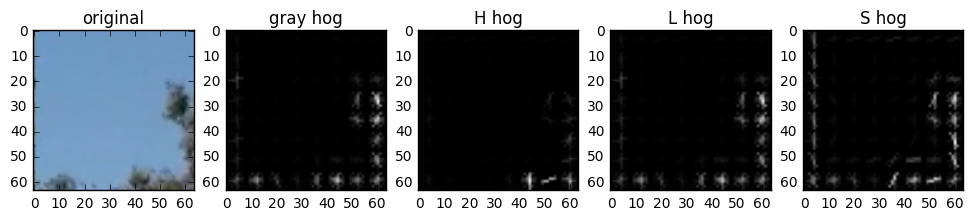

In [15]:
image=mpimg.imread(images_nocars[0])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hls  = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

# Plot a figure with all three bar charts
t,axarr = plt.subplots(1, 5, figsize=(12,3))
axarr[0].set_title('original')
axarr[0].imshow(image)

features, gray_hog = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True)
axarr[1].set_title('gray hog')
axarr[1].imshow(gray_hog, cmap='gray')

features, h_hog = get_hog_features(hls[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
axarr[2].set_title('H hog')
axarr[2].imshow(h_hog, cmap='gray')

features, l_hog = get_hog_features(hls[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
axarr[3].set_title('L hog')
axarr[3].imshow(l_hog, cmap='gray')

features, s_hog = get_hog_features(hls[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
axarr[4].set_title('S hog')
axarr[4].imshow(s_hog, cmap='gray')

In [16]:
# image space converter
def convert_image(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    return feature_image

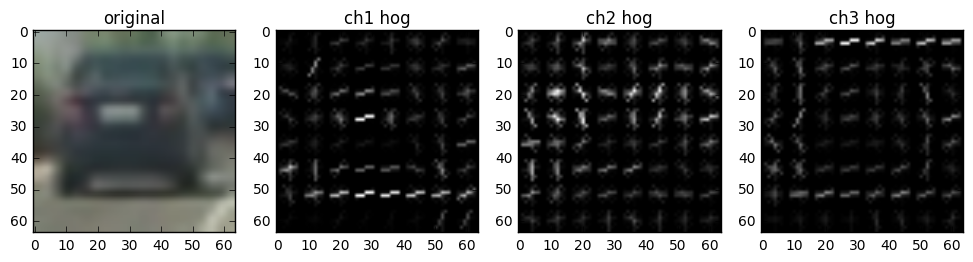

In [17]:
image=mpimg.imread(images_cars[0])
car_img_ycrcb = convert_image(image,'YCrCb')

# Plot a figure with all three bar charts
t,axarr = plt.subplots(1, 4, figsize=(12,3))
axarr[0].set_title('original')
axarr[0].imshow(image)

features, gray_hog = get_hog_features(car_img_ycrcb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
axarr[1].set_title('ch1 hog')
axarr[1].imshow(gray_hog, cmap='gray')

features, h_hog = get_hog_features(car_img_ycrcb[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
axarr[2].set_title('ch2 hog')
axarr[2].imshow(h_hog, cmap='gray')

features, l_hog = get_hog_features(car_img_ycrcb[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
axarr[3].set_title('ch3 hog')
axarr[3].imshow(l_hog, cmap='gray')



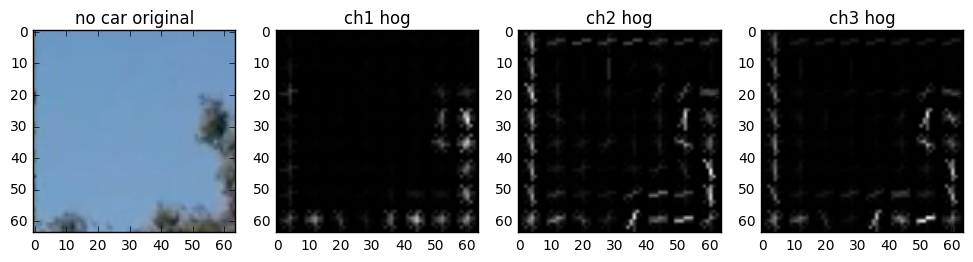

In [18]:
image=mpimg.imread(images_nocars[0])
car_img_ycrcb = convert_image(image,'YCrCb')

# Plot a figure with all three bar charts
t,axarr = plt.subplots(1, 4, figsize=(12,3))
axarr[0].set_title('no car original')
axarr[0].imshow(image)

features, gray_hog = get_hog_features(car_img_ycrcb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
axarr[1].set_title('ch1 hog')
axarr[1].imshow(gray_hog, cmap='gray')

features, h_hog = get_hog_features(car_img_ycrcb[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
axarr[2].set_title('ch2 hog')
axarr[2].imshow(h_hog, cmap='gray')

features, l_hog = get_hog_features(car_img_ycrcb[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
axarr[3].set_title('ch3 hog')
axarr[3].imshow(l_hog, cmap='gray')

In [20]:
spatial_size = (32,32)
hist_bins = 32
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_space = 'YCrCb'
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

spatial_feat=True
hist_feat=True
hog_feat=True

In [68]:

# Define a function to compute binned color features  
# Borrowed form udacity course tutorial
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    ch1_features = cv2.resize(img[:,:,0], size).ravel() 
    ch2_features = cv2.resize(img[:,:,1], size).ravel() 
    ch3_features = cv2.resize(img[:,:,2], size).ravel() 
    features = np.hstack((ch1_features,ch2_features, ch3_features))
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# unless png data read by mpimg has been scaled back to 0-255
# Borrowed from udacity coruse tutorial
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# Assumes image has RGB which is the default order when img is read
# using mpimg
# Borrowed from 
def extract_features(imgs, color_space='RGB', hog_space='RGB', img_type='JPG', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        if img_type == 'PNG': # PNG images read by mpimg are in range 0-1. 
            image = (image*255).astype(np.uint8)
            #image = image.astype(np.float32)/255 # Need to be scaled to 0-1
        # apply color conversion if other than 'RGB'
        feature_image = convert_image(image, color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)

        
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_feature_image = convert_image(image, hog_space)

            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(hog_feature_image.shape[2]):
                    hog_features.append(get_hog_features(hog_feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(hog_feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [69]:
#extract features
car_features = extract_features(images_cars, color_space=color_space, hog_space = hog_space, img_type= 'PNG',
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(images_nocars, color_space=color_space, hog_space = hog_space, img_type= 'PNG',
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

In [70]:
 # Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [71]:
import time
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

17.52 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
0.016 Seconds to predict 10 labels with SVC


In [72]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    # modified the sample function as it works only for overlap = 0.5
    nx_windows = np.int((xspan-xy_window[0])/nx_pix_per_step) + 1
    ny_windows = np.int((yspan-xy_window[1])/ny_pix_per_step) + 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def get_all_slide_windows(img, x_start_stop_list, y_start_stop_list, xy_window_list, xy_overlap_list):
    window_list =[]
    for i in range(len(x_start_stop_list)):
        window_list += slide_window(img, x_start_stop=x_start_stop_list[i], 
                                       y_start_stop=y_start_stop_list[i], 
                                       xy_window=xy_window_list[i], 
                                       xy_overlap=xy_overlap_list[i])
    return window_list


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
# TODO: Implement logic to take hog only once and then sub sample for each window 
def single_img_features(img, color_space='RGB', hog_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_space != 'RGB':
            if hog_space == 'HSV':
                hog_feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif hog_space == 'LUV':
                hog_feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif hog_space == 'HLS':
                hog_feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif hog_space == 'YUV':
                hog_feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif hog_space == 'YCrCb':
                hog_feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: hog_feature_image = np.copy(img)      

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(hog_feature_image.shape[2]):
                hog_features.extend(get_hog_features(hog_feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(hog_feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows_old(img, windows, clf, scaler, color_space='RGB', hog_space='RGB',
                    spatial_size=(32, 32), hist_bins=32, 
                    orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))   
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, hog_space=hog_space,
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows




# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, clf, scaler, color_space='RGB', hog_space = 'RGB',
                    window_scales = [1.0, 1.5], spatial_size=(32, 32), hist_bins=32, 
                    orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
    #1) subset image to fixed lower size
    ytop=400
    ybot=656
    window_size=64 
    cells_per_step = 2
    pixels_per_step = cells_per_step*pix_per_cell #16
    sub_img = img[ytop:ybot, :, :]
    imshape = sub_img.shape

    #3) Create an empty list to receive positive detection windows
    on_windows = []
    all_windows = []
    
    
    for scale in window_scales:
        #scale the image 
        # scale of 1 will mean window of size 64
        # scale of 1.5 will mean window of size 96 and so on
        scaled_image = cv2.resize(sub_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        scaled_imshape = scaled_image.shape
        #print (scale, scaled_imshape)

        #print(scaled_imshape[1])
        #print(pixels_per_step)
        #print(window_size)
        feature_image = convert_image(scaled_image, color_space)
        hog_image = convert_image(scaled_image, hog_space)
        
        #4) Calculate no. of steps in each direction 
        nx_step = (scaled_imshape[1]-window_size) // (pixels_per_step) + 1 #(1280-64)/16+1 = 77
        ny_step = (scaled_imshape[0]-window_size) // (pixels_per_step) + 1
    
        #5) get hog for the entire image
        if hog_feat:
            hog_output = []
            for channel in range(hog_image.shape[2]):
                hog_output.append(get_hog_features(hog_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=False))      
    
        #6) extract features for each window
        for x in range(nx_step):
            for y in range(ny_step):
                #6a) calculate window pixels 
                x_start = x*pixels_per_step # for x = 5, x_start = 5*16=80
                x_stop = x_start + window_size #80+64 = 144
                y_start = y*pixels_per_step
                y_stop = y_start+window_size
                
                #get bounding box
                bbox= (( np.int(x_start*scale),  #80
                         np.int((y_start)*scale+ytop)
                       ), 
                       ( np.int(x_stop*scale), #144
                         np.int((y_stop)*scale+ytop)
                       )
                      )
                
                #add this bbox to all_windows
                all_windows.append(bbox)

                # Now we extract features and run classfier on this window
                #define empty array to hold features
                img_features = []
                #6b) get the windowed image
                test_img = cv2.resize(feature_image[y_start:y_stop, x_start:x_stop], (64, 64))
                #6c) Compute spatial features if flag is set
                if spatial_feat == True:
                    spatial_features = bin_spatial(test_img, size=spatial_size)
                    img_features.append(spatial_features)
                #6d) Compute histogram features if flag is set
                if hist_feat == True:
                    hist_features = color_hist(test_img, nbins=hist_bins)
                    img_features.append(hist_features)
                #6e) get HOG features if flag is set
                if hog_feat == True:
                    hog_x_cell_start = x*cells_per_step #5*2 = 10
                    hog_x_cell_stop = hog_x_cell_start + window_size//pix_per_cell-cell_per_block+1 # 10+64/8-2+1 = 17
                    hog_y_cell_start = y*cells_per_step 
                    hog_y_cell_stop = hog_y_cell_start + window_size//pix_per_cell-cell_per_block+1
                    #print(hog_x_cell_start, hog_x_cell_stop, hog_y_cell_start, hog_y_cell_stop)
                    if hog_channel == 'ALL':
                        hog_features = []
                        for channel in range(hog_image.shape[2]):
                            hog_features.append(hog_output[channel][hog_y_cell_start:hog_y_cell_stop, hog_x_cell_start:hog_x_cell_stop].ravel())
                        hog_features = np.ravel(hog_features)        
                    else:
                        hog_features = hog_output[hot_channel][hog_y_cell_start:hog_y_cell_stop, hog_x_cell_start:hog_x_cell_stop].ravel()

                    #for channel in hog_channel:
                    #    #print (hog_output[channel][hog_y_cell_start:hog_y_cell_stop, hog_y_cell_start:hog_y_cell_stop].shape)
                    #   hog_features.extend(hog_output[channel][hog_y_cell_start:hog_y_cell_stop, hog_y_cell_start:hog_y_cell_stop].ravel())      

                    #6f) Append features to list
                    img_features.append(hog_features)

                #print(len(img_features))
                features = np.concatenate(img_features)
                #print(features.shape)

                #7) Scale extracted features to be fed to classifier
                test_features = scaler.transform(np.array(features).reshape(1, -1))
                #8) Predict using your classifier
                prediction = clf.predict(test_features)
                #9) If positive (prediction == 1) then save the window
                if prediction == 1:
                    on_windows.append(bbox)
                    #plt.figure()
                    #plt.imshow(test_img)
                
    #8) Return windows for positive detections
    return all_windows, on_windows


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [102]:
def get_heat(img, bbox_list):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold=2):
    # Zero out pixels below the threshold
    result = np.copy(heatmap)
    result[result <= threshold] = 0
    # Return thresholded map
    return result

def draw_labeled_bboxes(img, heatmap, color=(0, 0, 255), thick=6):
    # Iterate through all detected cars
    result_img = np.copy(img)
    labels = label(heatmap)
    bboxes=[]
    #for car_number in range(1, 2):
    car_number=1
    # Find pixels with each car_number label value
    nonzero = (labels[0] == car_number).nonzero()
    # Identify x and y values of those pixels
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Define a bounding box based on min/max x and y
    bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
    # Draw the box on the image
    cv2.rectangle(result_img, bbox[0], bbox[1], color, thick)
    bboxes.append(bbox)
    # Return the image
    return result_img, bboxes


class TrackHeatMaps:
        def __init__(self, n=5):
            self.n = n
            self.last_n_frames = [np.zeros((720,1280)) for i in range(self.n)]
            
        def add_row(self,row):
            self.last_n_frames = self.last_n_frames[1:]
            self.last_n_frames.append(np.copy(row))

In [103]:
def visualize_plots(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        #plt.title(i+1)
        if len(img.shape) < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [104]:
def pipeline(img, clf, scaler, color_space='RGB', hog_space='RGB', img_type='JPG',
                    track_frames = False, window_scales=[1], spatial_size=(32, 32), hist_bins=32, 
                    orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True, color=(0,0,255), thick=6, threshold=2, visualize=True):

    # trackmaps is a global variable
    global trackmaps
    
    # check if image needs scaling based on img_type
    result_img = np.copy(img)
    if img_type == 'PNG':
        result_img = (result_img*255).astype(np.uint8)
        #result_img = result_img.astype(np.float32)/255 # Need to be scaled to 0-1 
    # search over all windows, extracting the image for window region and then run classifier to check
    # if window is hot
    all_windows, hot_windows = search_windows(result_img, clf=clf, scaler=scaler, color_space=color_space, hog_space=hog_space,
                        window_scales=window_scales, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    heatmap = get_heat(img, hot_windows)
    if track_frames:
        trackmaps.add_row(heatmap)
        # get heatmap for hot windows across frames
        for h_map in trackmaps.last_n_frames:
            heatmap+= h_map
    
    #apply threholding to remove False Positives
    thresholded_heatmap = apply_threshold(heatmap, threshold=threshold)

    #draw labeled boxes to merge multiple detections into a single rectangle
    labeled_image, labeled_boxes = draw_labeled_bboxes(np.copy(img), thresholded_heatmap, color=color, thick=thick)

    if visualize:
        # all boxes_image
        all_boxes_image = draw_boxes(np.copy(img), all_windows, color=color, thick=thick)

        # draw boxes before merging and thresholding
        hot_boxed_image = draw_boxes(np.copy(img), hot_windows, color=color, thick=thick)
        images = [img, hot_boxed_image, get_heat(img, hot_windows), heatmap, thresholded_heatmap, labeled_image] 
        titles = ['Original Image', 'Positive regions', 'Frame Heatmap', 
                  'Cumulative Heatmap(5 frame rolling)', 'Cumulative Heatmap thresholded' ,
                  'Final Image']
        #images = [img, hot_boxed_image] 
        #titles = ['Orginal image', 'Detected Windows']
        fig = plt.figure(figsize=(20,15))
        visualize_plots(fig, 3, 2, images, titles)
        
    return labeled_image

def process_img(img):
    #print(track_frames)
    labeled_image = pipeline(
                    img, clf=svc, scaler=X_scaler, color_space=color_space, 
                    hog_space=hog_space, img_type='JPG',
                    track_frames=track_frames, window_scales=window_scales,
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat, color=color, thick=thick, threshold=threshold, visualize=visualize)
    return labeled_image




In [105]:
track_frames = True
window_scales = [1, 1.5]
threshold=9
visualize=False
color=(0, 0, 255)
thick=2



In [106]:
trackmaps = TrackHeatMaps(n=5)
test_img = mpimg.imread('test_images/test4.jpg')
tmp = process_img(test_img)

plt.imshow(tmp)

IndexError: tuple index out of range

In [81]:
# Run pipeline
trackmaps = TrackHeatMaps(n=5)
video_output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(process_img)
%time output_clip.write_videofile(video_output, audio=False)

TypeError: only integer arrays with one element can be converted to an index

In [12]:
def get_hog_data(img, colorspace, orient, pixpercell, cellperblock, featuresize):
    Xhog = np.zeros((img.shape[0], featuresize), dtype=np.float32)

    for idx in range(img.shape[0]):
        if colorspace == 'gray':
            x = cv2.cvtColor(img[idx], cv2.COLOR_RGB2GRAY)
        else:
            hls = cv2.cvtColor(img[idx], cv2.COLOR_RGB2HLS)
            if colorspace=='h':
                x = hls[:,:,0]
            elif colorspace=='l':
                x = hls[:,:,1]
            else:
                x = hls[:,:,2]
        
        f = get_hog_features(x, orient, pixpercell, cellperblock)
        Xhog[idx] = f
        
    return Xhog

In [15]:
HOG_ORIENT = 10
HOG_PPC = 16
HOG_CPB = 2
HOG_SIZE = 360

In [16]:
def preprocess_input(imgs):
    hot_data = get_hog_data(imgs, 'l', HOG_ORIENT, HOG_PPC, HOG_CPB, HOG_SIZE)
    X_scaler = StandardScaler().fit(hot_data)
    X = X_scaler.transform(hot_data)
    return X

In [38]:
X_train = preprocess_input(x_train)
X_test =  preprocess_input(x_test)
clf =LinearSVC()
clf.fit(X_train, y_train)
# Confirm evaluation results
print(clf.score(X_train, y_train), clf.score(X_test, y_test))

0.956996058559 0.943975225225


In [18]:
IMG_WIDTH = 1280
IMG_HEIGTH = 720
IMG_CENTER = 640
SLW_OVERLAP = .05
SLW_WINDOWS = [
    (96,  256),
    (150, 196),
    (200, 128),
    (230, 96),
]

In [19]:
def get_sliding_windows(img):
    windows = []
    images = []
    
    # For every defined sliding window
    for bottom_offset, window_size in SLW_WINDOWS:
        # Define step and total number of windows
        step = int(window_size * SLW_OVERLAP)
        total_windows = IMG_WIDTH // step + 1
        
        # For every single window
        for i in range(total_windows):
            # Define center and window width
            center = i * step
            deviation = float(center - IMG_CENTER) / IMG_CENTER
            window_width = int((window_size / 2) * (1. + deviation ** 2))
            
            # Calculate left and right X positions
            if center - window_width < 0:
                xleft = 0
                xrigh = center + window_width
            elif center + window_width > IMG_WIDTH:
                xleft = center - window_width
                xrigh = IMG_WIDTH
            else:
                xleft = center - window_width
                xrigh = center + window_width
                
            # Calculate Y positions
            yleft = IMG_HEIGTH - bottom_offset
            yrigh = yleft - window_size
            
            # Remember box coordinates and image patch
            windows.append([(xleft, yleft), (xrigh, yrigh)])
            images.append(img[yrigh:yleft, xleft:xrigh, :])
            
    return windows, images

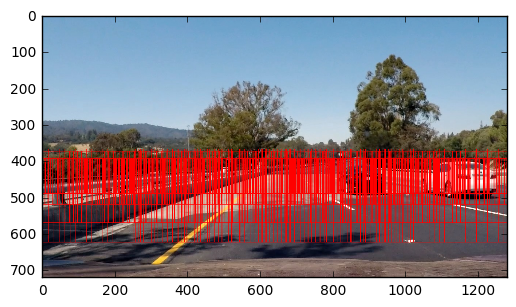

In [39]:
# Just visualize how sliding window look like
test_img = mpimg.imread('test_images/test4.jpg')
windows, _ = get_sliding_windows(test_img)
for p1, p2 in windows:
    cv2.rectangle(test_img, p1, p2, (255,0,0), 1)
plt.imshow(test_img)

In [21]:
# If image patch is not 64x64, resize it
def prepare_image_patch_for_classifier(img):
    if img.shape[0] != 64 or img.shape[1] != 64:
        img = cv2.resize(img, (64, 64))
    img = np.expand_dims(img, axis=0)
        
    return img

In [108]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list



# Get heatmap of positive detections
def get_vehicles_heatmap_from_image(source_image, probability=.85):
    # Get all sliding windows and image patches
    windows = slide_window(source_image)
    images =np.copy(source_image)
    # Define heatmap as zeros image
    heatmap = np.zeros((source_image.shape[0], source_image.shape[1]), dtype=np.uint8)
    
    i = 0
    for i in range(len(windows)):
        wnd, img = windows[i], images[i]
        
        # Preprocess image patch
        img = prepare_image_patch_for_classifier(img)
        img = preprocess_input(img)
        
        # Classify, but take not 0 or 1 class prediction, but raw probability
        clfproba = clf.predict(img)
        
        # Only if probability is high enouth, consider patch as vehicle and update heatmap
        #if clfproba[0] >= probability:
        if clfproba[0]==1:
            xleft, yleft = wnd[0]
            xrigh, yrigh = wnd[1]
            heatmap[yrigh:yleft, xleft:xrigh] += 1

    return heatmap

In [109]:
# Take boundary boxes from a heatmap of positive detections
def get_boundaries_from_heatmap(heatmap):
    # If heatmap is empty, return empty boundaries
    if(heatmap.max() == 0):
        return []
    
    # Consider only heatmap valies greater than 1
    thresh = 1
    mask = np.zeros_like(heatmap)
    mask[heatmap > thresh] = 1
    
    # Use skimage.measure.label to label regions on the mask
    labeled = label(mask)
    boxes = []
    
    # Use skimage.measure.regionprops to get regois our of labelled image. Keep only images with big area
    for region in regionprops(labeled):
        if region.area < 5000:
            continue
        
        minr, minc, maxr, maxc = region.bbox
        boxes.append(((minc, minr), (maxc, maxr)))
    return boxes

In [110]:
# Visualization
testimg = mpimg.imread('test_images/test4.jpg')
testimg_out = np.copy(testimg)
heatmap = get_vehicles_heatmap_from_image(testimg)
boxes = get_boundaries_from_heatmap(heatmap)
for box in boxes:
    p1, p2 = box
    print(p1)
    cv2.rectangle(testimg_out, p1, p2, (0,0,255), 3)

_, axarr = plt.subplots(1, 3, figsize=(16,5))
axarr[0].imshow(testimg)
axarr[1].imshow(heatmap)
axarr[2].imshow(testimg_out)

error: ..\..\..\modules\imgproc\src\color.cpp:7646: error: (-215) (scn == 3 || scn == 4) && (depth == CV_8U || depth == CV_32F) in function cv::ipp_cvtColor


In [99]:
# Get heatmap of positive detections
def getImages222(source_image,windows, probability=.85):

    # Define heatmap as zeros image
    heatmap = np.zeros((source_image.shape[0], source_image.shape[1]), dtype=np.uint8)
    
    i = 0
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        print(window[1][1])
        #3) Extract the test window from original image
        test_img = cv2.resize(source_image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        img = prepare_image_patch_for_classifier(test_img)
        img = preprocess_input(img)
        
        clfproba = clf.predict(img)
        # Classify, but take not 0 or 1 class prediction, but raw probability
        if clfproba[0]==1:
            xleft, yleft = wnd[0]
            xrigh, yrigh = wnd[1]
            heatmap[yrigh:yleft, xleft:xrigh] += 1
    #8) Return windows for positive detections
    return heatmap


    

In [87]:


def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features




spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins


# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


Test Accuracy of SVC =  0.922015765766


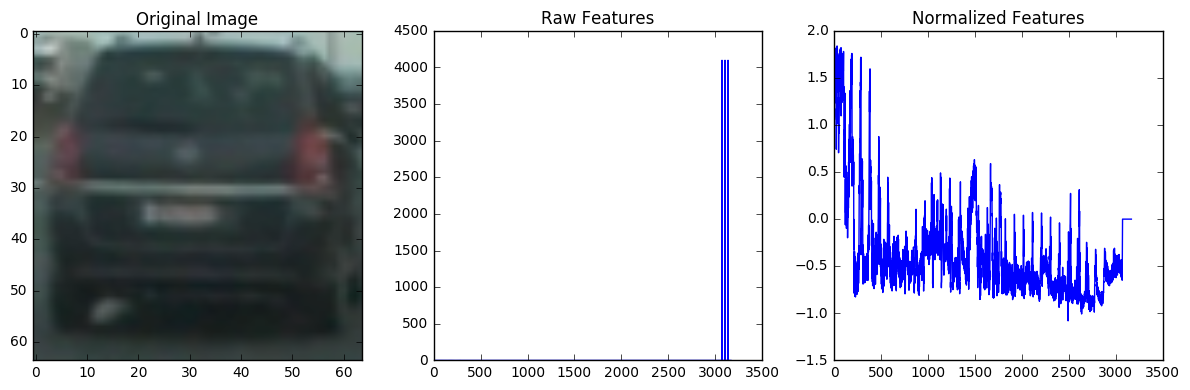

In [70]:

cars=[]
no_cars=[]

images_cars = glob.glob('data/vehicles/*/*.png')
for img_path in images_cars:
    if img_path is None:
        continue
   
    cars.append(img_path)

images_nocars = glob.glob('data/non-vehicles/*/*.png')
for img_path in images_nocars:

    no_cars.append(img_path)
    
    
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(no_cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [71]:
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [72]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [73]:
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [74]:
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

Test Accuracy of SVC =  0.915259009009


In [77]:
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

My SVC predicts:  [ 1.  1.  0.  0.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]


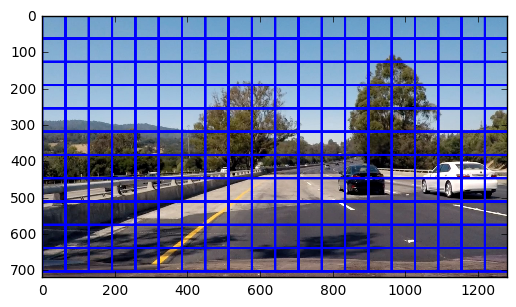

In [79]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


image = mpimg.imread('test_images/test4.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)




In [90]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)


color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

ValueError: operands could not be broadcast together with shapes (1,2580) (816,) (1,2580) 

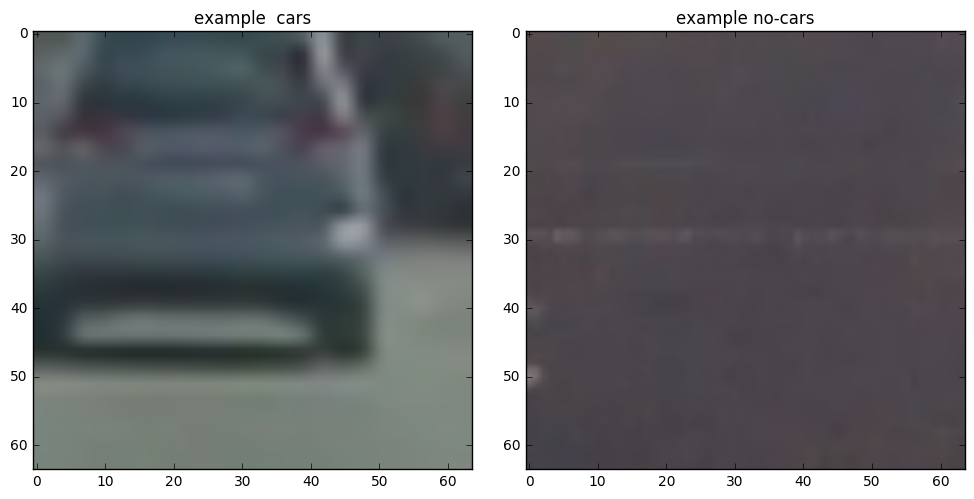

In [73]:
ind = np.random.randint(0,len(images_cars ))
draw2Img(cars[ind],no_cars[ind],'example  cars','example no-cars')

In [74]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Generating bin centers
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Concatenate the histograms into a single feature vector
    #hist_features = None
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

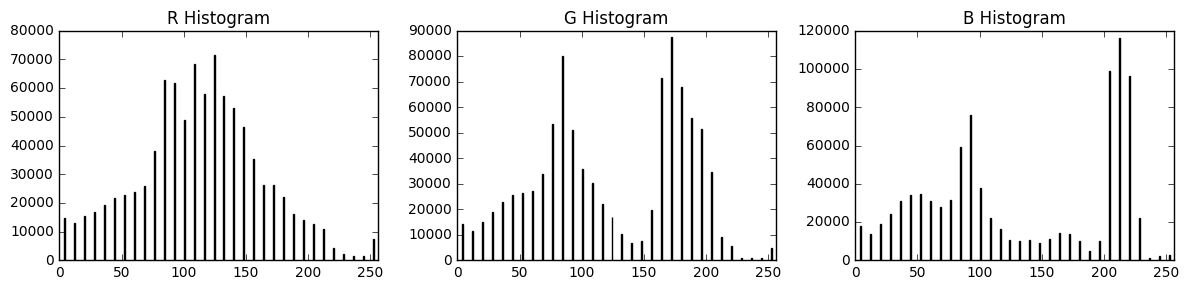

In [75]:
image = mpimg.imread('test_images/test4.jpg')
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

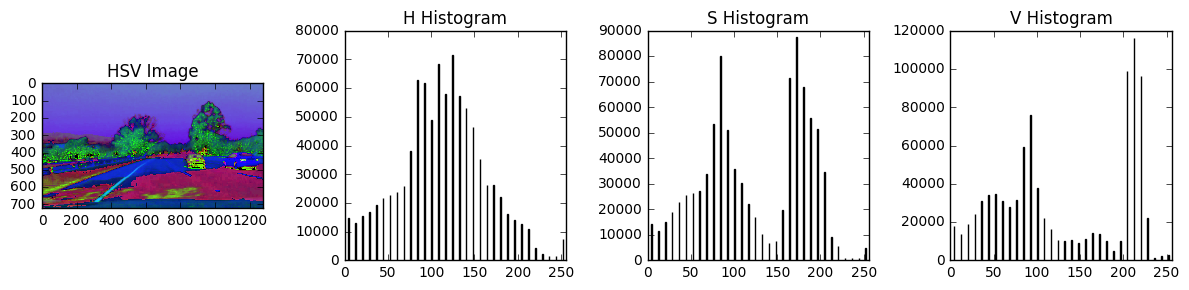

In [76]:
img_copy = np.copy(image)
car_image_hsv = cv2.cvtColor(img_copy, cv2.COLOR_RGB2HSV)
rh, gh, bh, bincen, feature_vec = color_hist(car_image_hsv, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(car_image_hsv)
    plt.title('HSV Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('H Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('S Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

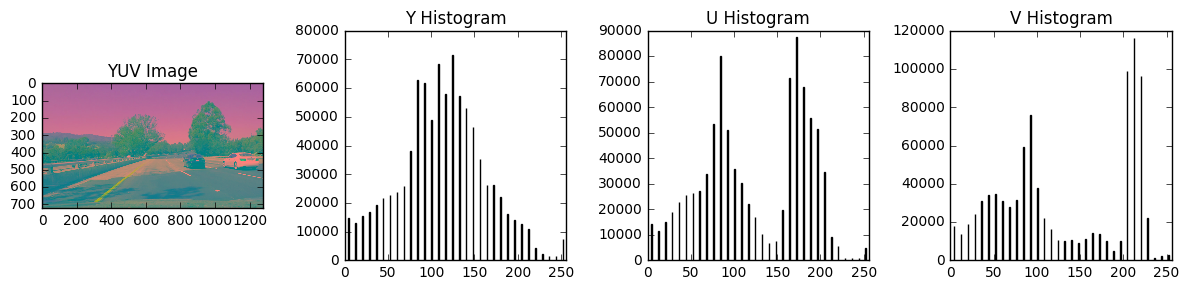

In [77]:
img_copy3 = np.copy(image)
car_image_YUV = cv2.cvtColor(img_copy3, cv2.COLOR_RGB2YUV)
rh, gh, bh, bincen, feature_vec = color_hist(car_image_YUV, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(car_image_YUV)
    plt.title('YUV Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('U Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

In [78]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

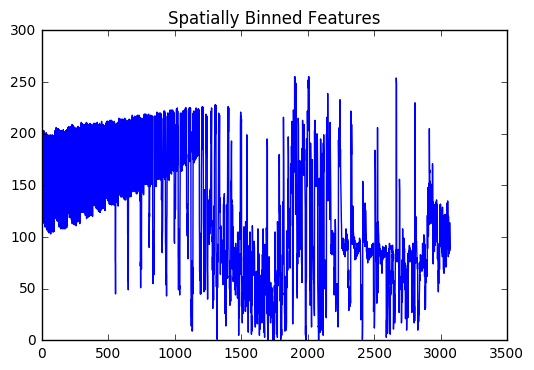

In [79]:
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

In [80]:
def get_hog_features(img, orient=12, pix_per_cell=6, cell_per_block=2, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

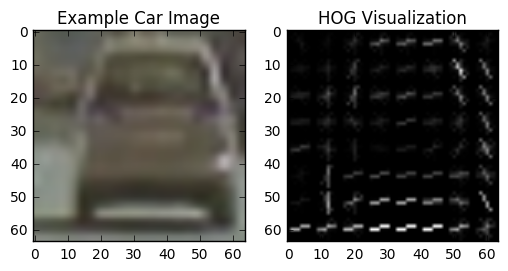

In [81]:
# # Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
example_car = cars[ind]
example_car = cv2.cvtColor(example_car, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(example_car, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(example_car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


In [82]:
### Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


(64, 64, 3)


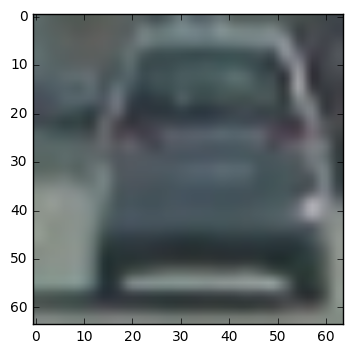

In [83]:
example_car = cars[ind]
print(example_car.shape)
plt.imshow(example_car)

In [84]:
def extract_features(imgs, color_space='RGB', spatial_size=(64, 64),
                        hist_bins=64, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
       
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [85]:
#extract the features for cars/ noncars
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(no_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [48]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [97]:
def search_windows(img, windows, clfs, scaler, color_space='RGB', 
                    spatial_size=(64, 64), hist_bins=64, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier (now uses multiple classifiers)
        predictions = 0 #We want all classifiers to be positive in agreement
       
        prediction = clfs.predict(test_features)
        predictions+= prediction
        #7) If positive (prediction == 1) then save the window (if all predictions greater than a threshold)
        if predictions >= .5: #half of classifiers think car...
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [86]:
bad_indices = np.where(np.isinf(notcar_features))

print(bad_indices)

(array([], dtype=int64), array([], dtype=int64))


In [89]:
#Define the features and labels vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [90]:
import time

#Fit the classifier and make a prediction
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 19440
0.09 Seconds to train SVC...
Test Accuracy of SVC =  1.0


In [93]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(64,64),
                        hist_bins=64, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [ ]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [ ]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

#define 5 spaces to grab windows of different size
windows = []
# # 1) from .4 - .55
y_start_stop = [int(image.shape[0]*.3), int(image.shape[0]*.45)] # Min and max in y to search in slide_window()
windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(32,32), xy_overlap=(0.75, 0.75))
if len(windows1) > 0:
    windows += windows1
# 2) from .55 to .70 of image
y_start_stop = [int(image.shape[0]*.35), int(image.shape[0]*.6)] # Min and max in y to search in slide_window()
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64,64), xy_overlap=(0.75, 0.75))
if len(windows2) > 0:
    windows += windows2
# 3) from .70 to .85
y_start_stop = [int(image.shape[0]*.5), int(image.shape[0]*.75)] # Min and max in y to search in slide_window()
windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96,96), xy_overlap=(0.75, 0.75))
if len(windows3) > 0:
    windows = windows + windows3
# 4) from .75 to .9 of image
y_start_stop = [int(image.shape[0]*.65), int(image.shape[0]*.9)] # Min and max in y to search in slide_window()
windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128,128), xy_overlap=(0.75, 0.75))
if len(windows4) > 0:
    windows += windows4

# 5) from .85 to .9 of image
y_start_stop = [int(image.shape[0]*.65), int(image.shape[0]*.9)] # Min and max in y to search in slide_window()
windows5 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(160,160), xy_overlap=(0.75, 0.75))
if len(windows5) > 0:
    windows += windows5

#one last one for a very large window area
y_start_stop = [int(image.shape[0]*.5), int(image.shape[0]*.9)] # Min and max in y to search in slide_window()
windows6 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(220,220), xy_overlap=(0.25, 0.25))
if len(windows6) > 0:
    windows += windows6

# y_start_stop = (int(image.shape[0]*.5),int(image.shape[0]))
# windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(96,96), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
print('Number of windows: %d' % len(hot_windows))
plt.imshow(window_img)